In [1]:
import tweepy as tw
import os 
import re
import pandas as pd
import time
from datetime import date
os.chdir(r"C:\Users\Cheik\iCloudDrive\Desktop\MIM\Org_Behav\Projet")
#os.chdir("/Users/cheiksamassa/Desktop/MIM/Org_Behav/projet")
import nltk 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cheik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
###Twitter####
# initialize api instance
auth = tw.OAuthHandler(consumer_key='***************************',
                        consumer_secret='***********************************')

auth.set_access_token('************************************************',
                        '*****************************************')
api = tw.API(auth, wait_on_rate_limit=True)

# Tweets scrapping

In [11]:
"""Function to scrape tweets from Twitter Api (using developper account) including sleeping time (3000 tweets per 15 minutes), SOURCE: https://medium.com/@leowgriffin/scraping-tweets-with-tweepy-python-59413046e788"""

def scraptweets(search_words, date_since, numTweets, numRuns):
    
    # Define a for-loop to generate tweets at regular intervals
    # We cannot make large API call in one go. Hence, let's try T times
    
    # Define a pandas dataframe to store the date:
    db_tweets = pd.Darame(columns = ['username', 'tweed_id_str','acctdesc', 'location', 'following',
                                         'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts',
                                        'retweetcount', 'tweet_text', 'hashtags']
                                )
    
    program_start = time.time()
    for i in range(0, numRuns):
        # We will time how long it takes to scrape tweets for each run:
        start_run = time.time()
        
        # Collect tweets using the Cursor object
        # .Cursor() returns an object that you can iterate or loop over to access the data collected.
        # Each item in the iterator has various attributes that you can access to get information about each tweet
        tweets = tw.Cursor(api.search, q=search_words, lang="en", since=date_since, tweet_mode='extended').items(numTweets)
# Store these tweets into a python list
        tweet_list = [tweet for tweet in tweets]
# Obtain the following info (methods to call them out):
        # user.screen_name - twitter handle
        # user.description - description of account
        # user.location - where is he tweeting from
        # user.friends_count - no. of other users that user is following (following)
        # user.followers_count - no. of other users who are following this user (followers)
        # user.statuses_count - total tweets by user
        # user.created_at - when the user account was created
        # created_at - when the tweet was created
        # retweet_count - no. of retweets
        # (deprecated) user.favourites_count - probably total no. of tweets that is favourited by user
        # retweeted_status.full_text - full text of the tweet
        # tweet.entities['hashtags'] - hashtags in the tweet
# Begin scraping the tweets individually:
        noTweets = 0
        for tweet in tweet_list:
            # Pull the values
            username = tweet.user.screen_name
            tweed_id_str=tweet.id_str
            acctdesc = tweet.user.description
            location = tweet.user.location
            following = tweet.user.friends_count
            followers = tweet.user.followers_count
            totaltweets = tweet.user.statuses_count
            usercreatedts = tweet.user.created_at
            tweetcreatedts = tweet.created_at
            retweetcount = tweet.retweet_count
            hashtags = tweet.entities['hashtags']
            
            try:
                tweet_text = tweet.retweeted_status.full_text
            except AttributeError:  # Not a Retweet
                tweet_text = tweet.full_text
# Add the 11 variables to the empty list - ith_tweet:
            ith_tweet = [username, tweed_id_str, acctdesc, location, following, followers, totaltweets,
                         usercreatedts, tweetcreatedts, retweetcount, tweet_text, hashtags]
# Append to dataframe - db_tweets
            db_tweets.loc[len(db_tweets)] = ith_tweet
# increase counter - noTweets  
            noTweets += 1
        
        # Run ended:
        end_run = time.time()
        duration_run = round((end_run-start_run)/60, 2)
        
        print('no. of tweets scraped for run {} is {}'.format(i + 1, noTweets))
        print('time take for {} run to complete is {} mins'.format(i+1, duration_run))
        
        time.sleep(920) #15 minute sleep time
        
        
    '''# Once all runs have completed, save them to a single csv file:
    from datetime import datetime
    
    # Obtain timestamp in a readable format
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S')
# Define working path and filename
    path = os.getcwd()
    filename = path + '/data/' + to_csv_timestamp + '_anthropologie_tweets.csv'
# Store dataframe in csv with creation date timestamp
    db_tweets.to_csv(filename, index = False)
    '''
    program_end = time.time()
    
    print('Scraping has completed!')
    print('Total time taken to scrap is {} minutes.'.format(round(program_end - program_start)/60, 2))
    return db_tweets 

We create a query that will retrieve every tweet generated mentionning Anthropologie's official accounts or Urban Outfitters from last week.

In [12]:
words=["Anthropologie","UrbanOutfitters"]
OU=" OR "
search_words= OU.join([x for x in words])
search_words+=" AND (@AnthropologieEU OR @Anthropologie OR @urbn OR @UrbanOutfitters OR @uoeurope)"

search_words+=" -filter:retweets"
search_date="2020-09-29"
print(search_words)

Anthropologie OR UrbanOutfitters AND (@AnthropologieEU OR @Anthropologie OR @urbn OR @UrbanOutfitters OR @uoeurope) -filter:retweets


We create variable that will contain our returned object for further manipulations (dataframe). We estimated that in one week, these accounts couldn't have generated more than 10 000 twwets so we ask our scraping function to collect 2000 tweets every run (5)

In [13]:
db_tweets=scraptweets(search_words=search_words, date_since=search_date, numTweets=2000, numRuns=5)

no. of tweets scraped for run 1 is 2000
time take for 1 run to complete is 1.09 mins
no. of tweets scraped for run 2 is 2000
time take for 2 run to complete is 1.13 mins
no. of tweets scraped for run 3 is 2000
time take for 3 run to complete is 1.2 mins
no. of tweets scraped for run 4 is 2000
time take for 4 run to complete is 1.34 mins
no. of tweets scraped for run 5 is 2000
time take for 5 run to complete is 1.43 mins
Scraping has completed!
Total time taken to scrap is 82.85 minutes.


In [89]:
#db_tweets.to_excel("scrape_tweets_7_oct.xlsx")
db_tweets=pd.read_excel("scrape_tweets_7_oct.xlsx")

When we look at our dataframe we realize that we overestimated the number of tweets generated for these accounts: once every tweet published was collected, our scrapper kept on retrieving the same tweets until reaching 10 000 tweets collected (The function is not very well optimized and is very greedy. We have to get rid of the duplicate tweets

In [96]:
db_tweets=db_tweets.drop_duplicates(subset="tweed_id_str")

# We considered analyuzing tweets from Anthropologie and Urban Outfitters seperately but we abandonned that idea

#db_tweets_anth=db_tweets.loc[db_tweets["tweet_text"].str.contains("anthropologie", case=False, regex=True)] 
#db_tweets_urbn= db_tweets.loc[db_tweets["tweet_text"].str.contains("urban outfitters", case=False, regex=True)]

#print(len(db_tweets_anth),len(db_tweets_urbn))

428 47


In [9]:
#db_tweets["tweet_text"].to_excel("tweet_text_clean.xlsx")

# Wordclouds of tweets
## 1) Every tweets

In [94]:
db_tweets["hashtags"]=pd.Series(list(db_tweets["hashtags"]))

In [ ]:
""" String formating function (exclude special characters and cooncatenate every row of the DataFrame as one string)"""

def test (df): 
    
    def clean_tweet(string):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        pre=' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", string).split())
        
        return pre.lower()
   
    def df_clean(df1):
        df["clean_text"]=df["tweet_text"].apply(lambda x: clean_tweet(x))
        return(df)
    
    return(df_clean(df)) # On appelle notre fonction

#df0=test(df)

In [38]:
df1=test(db_tweets)

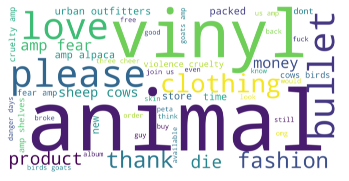

wordcloud.wordcloud.WordCloud

In [24]:
df1=test(db_tweets)
text_str= " ".join(tweet for tweet in df1["clean_text"])

from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(["stop","like","get","one","want","need","face","urban outfitters","oh","really","got","im","make","tell"]) # we add these words to our stopwords lists


%matplotlib inline
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="white",
                      max_font_size=100,
                      max_words=50, 
                      relative_scaling=0.5, #sort by frequency
                      collocations=True,
                      width=400,height=200,
                     scale=15).generate(text_str)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("second_tweets.jpeg")

type(wordcloud)

## 2) Controversial Tweets

We now separate the tweets that have been generated using one of these controversial words: 
- racism (and every other format of the word(eg. racist, race etc...)
- discriminate
- black lives matter
- nick
- nikki
- wages
- salary
- employment
- homophobia

In [56]:
df2=db_tweets.loc[db_tweets["tweet_text"].str.contains(r"\bracis[a-z]\b|\bdiscriminat[a-z]|\bblack lives matter\b|\blm\b|\bprofil[a-z]\b|\bnick\b|\bnikki\b|\bnicki\b|\bwage[a-z]\b|salary|\bemploy[a-z]\b|\black\b|boycott|homopho[a-z]",case=False,regex=True)]

11

In [ ]:
text_str= " ".join(tweet for tweet in df0["clean_text"])

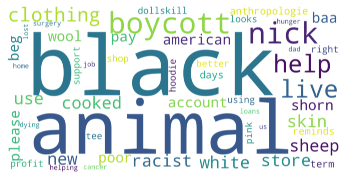

In [168]:
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(["jaa","stop","like","get","one","want","need","face","urban outfitters","oh","really","got","im","make","tell","thing","look"])

%matplotlib inline
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="white",
                      max_font_size=100,
                      max_words=50, 
                      relative_scaling=0.5, #sort by frequency
                      collocations=True,
                      width=400,height=200,
                     scale=15).generate(text_str)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("first_tweets.jpeg")


# Visualising hashtags of every tweets

In [106]:
liste=[] # gather every row that contains a hashtags i.e hashtag columnn is not empty (I haven't found any classier way yet)

for i,r in db_tweets["hashtags"].iteritems():
    if len(r)>=1:
        liste.append(i)
        

hashtags=db_tweets.loc[liste,"hashtags"]

hashtags=hashtags.apply(lambda x: x[0]["text"])

%matplotlib inline
sns.set(style="whitegrid")
plt.figure(figsize=(10,20))
ax=sns.countplot(y=hashtags).set_title("Number of tweets by hashtags")

0        [{'text': 'trinketdish', 'indices': [111, 123]}]
13      [{'text': 'ShameOnYou', 'indices': [0, 11]}, {...
20      [{'text': 'animalcruelty', 'indices': [194, 20...
32          [{'text': 'Sacramento', 'indices': [41, 52]}]
34      [{'text': 'WVU315', 'indices': [270, 277]}, {'...
                              ...                        
1914    [{'text': 'bestfriends', 'indices': [80, 92]},...
1941           [{'text': 'VEGAN', 'indices': [237, 243]}]
1986    [{'text': 'AnimalRights', 'indices': [60, 73]}...
1993    [{'text': 'putneversayneverbybrandyonvinyl', '...
3849    [{'text': 'FreeHK', 'indices': [33, 40]}, {'te...
Name: hashtags, Length: 102, dtype: object

In [172]:
#hashtags=pd.read_excel("hashtags 2.xlsx")
#hashtags=hashtags.iloc[:,0]

In [173]:
hashtags

0                           'trinketdish'
1                            'ShameOnYou'
2                         'AnimalCruelty'
3                            'Sacramento'
4                                'WVU315'
                      ...                
97                          'bestfriends'
98                        'AnimalCruelty'
99                        'AnimalCruelty'
100     'putneversayneverbybrandyonvinyl'
101                              'FreeHK'
Name: Column 1, Length: 102, dtype: object

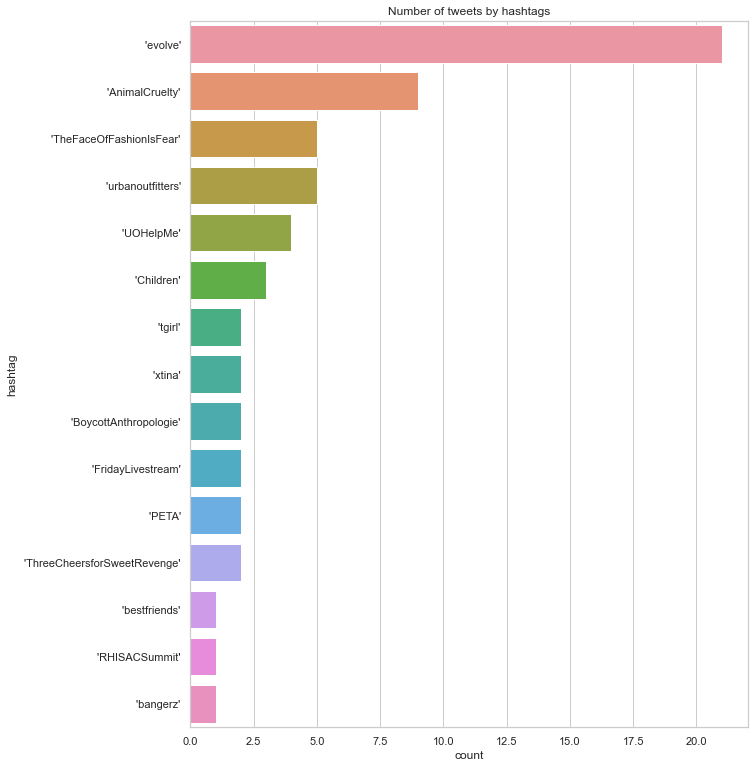

In [196]:
%matplotlib inline
sns.set(style="whitegrid")
plt.figure(figsize=(10,13))
ax=sns.countplot(orient='v',y=hashtags, order = hashtags.value_counts().iloc[:15].index).set_title("Number of tweets by hashtags")
plt.ylabel('hashtag')
plt.savefig("hashtags.jpeg")

In [107]:
#hashtags.to_excel("hashtags.xlsx")